## Do we see a wedge in our visibilities?

In [17]:
%load_ext autoreload
import sys
sys.path.append("..")
import imcurio as imc
from numpy.fft import fft,fftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload
B = imc.SimBox("../sims/HImesh_0512_z100.fits")
Bf = imc.SimBox("../sims/Sky_0512_z100_060.0-30.0.fits", conversions_from = B)
T=imc.TelSim(N=128)
vis = T.get_visibilities(B,vopts={'interpolation':'lasz','la':3.0})
visf = T.get_visibilities(Bf,vopts={'interpolation':'lasz','la':3.0})

Box size: 20.33-15.01 deg from z=0.81-1.22
Beam sigma: 1.99-2.44 deg from z=0.81-1.22
Beam sigma at the edge: 5.12 - 3.08 
Beam sigma: 1.99-2.44 deg from z=0.81-1.22
Beam sigma at the edge: 5.12 - 3.08 


In [51]:
def getPkVis(T,vis,Nkpar=256,Nkperp=15):
    Pk = np.zeros((Nkperp,Nkpar))
    Pkw = np.zeros_like(Pk)
    uv = np.sqrt(T.u_m**2+T.v_m**2)
    duv = ((uv-uv.min())/(1.001*uv.max()-uv.min())*Nkperp).astype(int)
    for cvis,ii in zip((vis).T,duv):
        ## lets pad with zeros
        cvis = np.hstack((cvis,np.zeros_like(cvis)))
        Nx=len(cvis)
        fcvis=fft(cvis)
        cPk = abs(fcvis[1:Nx//2+1]**2)+abs(fcvis[-1:-(Nx//2+1):-1]**2)
        cPkbin = cPk.reshape((-1,Nkpar)).mean(axis=0)
        Pk[ii,:] += cPkbin
        Pkw[ii,:] += 1
    Pk/=Pkw
    return Pk

In [52]:
## radial frequency binning 
dfpar=2*np.pi/(2*B.Lbox) ## we pad
## perpendicular
uv = np.sqrt(T.u_m**2+T.v_m**2)
kperlow = uv.min()*B.mtoIMpc
kperhigh = uv.max()*B.mtoIMpc

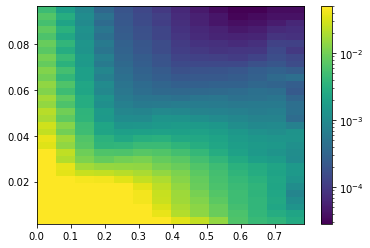

In [54]:
Pk = getPkVis(T,visf)
plt.imshow(Pk[1:,:32].T,origin='lower',norm=LogNorm(),aspect='auto',vmax=5e-2, 
           extent=(kperlow,kperhigh,0.5*dfpar,31.5*dfpar))
plt.colorbar()


Beam sigma: 1.99-2.44 deg from z=0.81-1.22
Beam sigma at the edge: 5.12 - 3.08 


[]

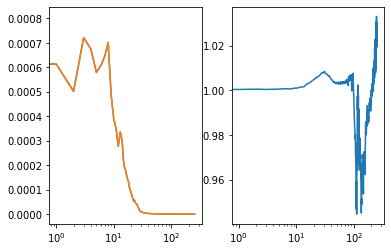

In [13]:
# does padding matter?
visfP = T.get_visibilities(Bf,pad=4,vopts={'interpolation':'lasz','la':3.0})
PkP = getPkVis(T,visfP)
plt.subplot(1,2,1); plt.plot(Pk[13,:]); plt.plot(PkP[13,:]); plt.semilogx()
plt.subplot(1,2,2); plt.plot(PkP[13,:]/Pk[13,:]); plt.semilogx()

Beam sigma: 1.99-2.44 deg from z=0.81-1.22
Beam sigma at the edge: 5.12 - 3.08 


[]

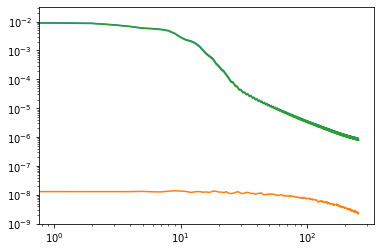

In [66]:
PkSig = getPkVis(T,vis)
Pk = getPkVis(T,visf)
plt.plot(Pk[10,:]); 
plt.plot(PkSig[10,:]);

Pk2 = getPkVis(T,T.get_visibilities(Bf,vopts={'interpolation':'lin'}))
plt.plot(Pk2[10,:]); 


plt.loglog()

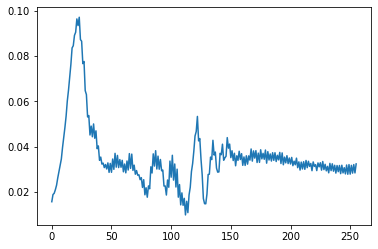

In [67]:
plt.plot(Pk[10,:]/Pk2[10,:]-1); 
#plt.loglog()

[]

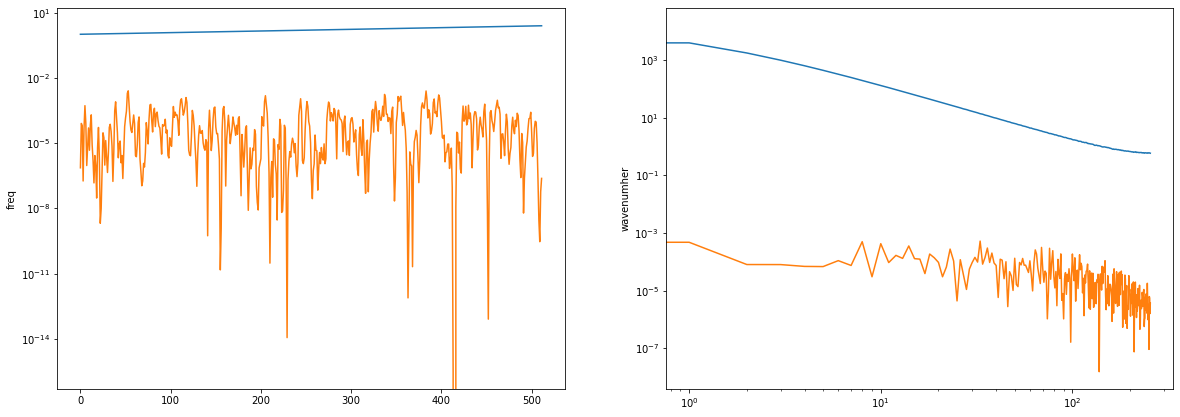

In [90]:
plt.figure(figsize=(20,7))
fg=Bf.box[20,20,:]; sg=B.box[20,20,:]

plt.subplot(1,2,1)
plt.plot(fg)
plt.plot(sg)
plt.ylabel("signal")
plt.ylabel("freq")
plt.semilogy()
plt.subplot(1,2,2)
plt.plot(abs(rfft(fg)**2)[1:])
plt.plot(abs(rfft(sg)**2)[1:])
plt.ylabel("Pk1D")
plt.ylabel("wavenumher")
plt.loglog()